In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class SVD_SGD_Recommender:
    def __init__(self, num_factors=50, learning_rate=0.005, reg=0.02, epochs=50):
        self.num_factors = num_factors
        self.learning_rate = learning_rate
        self.reg = reg
        self.epochs = epochs
        self.user_mapping = None
        self.item_mapping = None
        self.rating_mean = 0
        self.rating_max = 0
        self.rating_min = 0

    def fit(self, train_ratings, test_ratings, rating_mean, rating_max, rating_min):
        # Chuẩn hóa rating
        self.rating_mean = rating_mean
        self.rating_max = rating_max
        self.rating_min = rating_min

        self.user_mapping = {user_id: idx for idx, user_id in enumerate(train_ratings['user_id'].unique())}
        self.item_mapping = {item_id: idx for idx, item_id in enumerate(train_ratings['item_id'].unique())}
        
        train_ratings['user_idx'] = train_ratings['user_id'].map(self.user_mapping)
        train_ratings['item_idx'] = train_ratings['item_id'].map(self.item_mapping)
        
        test_ratings = test_ratings[test_ratings['item_id'].isin(self.item_mapping)]
        test_ratings['user_idx'] = test_ratings['user_id'].map(self.user_mapping)
        test_ratings['item_idx'] = test_ratings['item_id'].map(self.item_mapping)

        num_users = len(self.user_mapping)
        num_items = len(self.item_mapping)
        
        self.U = np.random.normal(scale=1./self.num_factors, size = (num_users, self.num_factors))
        self.V = np.random.normal(scale=1./self.num_factors, size = (num_items, self.num_factors))
        
        train_losses, test_losses, train_maes, test_maes, train_rmses, test_rmses = [], [], [], [], [], []
        
        for epoch in range(self.epochs):
            total_loss, total_mae, total_rmse = 0, 0, 0
            for row in train_ratings.itertuples():
                u, i, r = row.user_idx, row.item_idx, row.rating
                pred = self.U[u, :].dot(self.V[i, :].T)
                err = r - pred
                # Cập nhật U và V
                self.U[u, :] += self.learning_rate * (err * self.V[i, :] - self.reg * self.U[u, :])
                self.V[i, :] += self.learning_rate * (err * self.U[u, :] - self.reg * self.V[i, :])
                
                total_loss += err ** 2
                total_mae += abs(err)
                total_rmse += err ** 2
                
            train_losses.append(total_loss / len(train_ratings))
            train_maes.append(total_mae / len(train_ratings))
            train_rmses.append(np.sqrt(total_rmse / len(train_ratings)))
            
            test_loss, test_mae, test_rmse = self.evaluate(test_ratings)
            test_losses.append(test_loss)
            test_maes.append(test_mae)
            test_rmses.append(test_rmse)
            
            print(f"Epoch {epoch+1}: Loss={(total_loss / len(train_ratings)):.4f}, Train MAE={train_maes[-1]:.4f}, Test MAE={test_maes[-1]:.4f}, Train RMSE={train_rmses[-1]:.4f}, Test RMSE={test_rmses[-1]:.4f}")
        
        self.plot_metrics(train_losses, test_losses, train_maes, test_maes, train_rmses, test_rmses, test_ratings)

    def evaluate(self, test_ratings):
        total_loss, total_mae, total_rmse = 0, 0, 0
        count = 0
        for row in test_ratings.itertuples():
            u, i, r = row.user_idx, row.item_idx, row.rating
            pred = self.U[u, :].dot(self.V[i, :].T)
            err = r - pred
            
            total_loss += err ** 2
            total_mae += abs(err)
            total_rmse += err ** 2
            count += 1
        
        return total_loss / count, total_mae / count, np.sqrt(total_rmse / count)

    def predict(self, user_id, item_id):
        if user_id not in self.user_mapping or item_id not in self.item_mapping:
            return None  
        
        user_idx = self.user_mapping[user_id]
        item_idx = self.item_mapping[item_id]
        pred_norm = self.U[user_idx, :].dot(self.V[item_idx, :].T)
        # pred_denorm = pred_norm * (self.rating_max - self.rating_min + 1e-8) + self.rating_mean
        return np.clip(pred_norm, 0, 5)


    def plot_metrics(self, train_losses, test_losses, train_maes, test_maes, train_rmses, test_rmses, test_ratings):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss Over Epochs')
        
        plt.subplot(1, 3, 2)
        plt.plot(train_maes, label='Train MAE')
        plt.plot(test_maes, label='Test MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.title('MAE Over Epochs')
        
        plt.subplot(1, 3, 3)
        plt.plot(train_rmses, label='Train RMSE')
        plt.plot(test_rmses, label='Test RMSE')
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.legend()
        plt.title('RMSE Over Epochs')
        
        real_values, predicted_values = [], []
        for row in test_ratings.itertuples():
            u, i, r = row.user_idx, row.item_idx, row.rating
            pred = self.U[u, :].dot(self.V[i, :].T)
            real_values.append(r)
            predicted_values.append(pred)
        
        plt.figure(figsize=(7, 5))
        plt.scatter(real_values, predicted_values, alpha=0.1, color='Green')
        plt.xlabel("Actual Ratings")
        plt.ylabel("Predicted Ratings")
        plt.title("Actual vs Predicted Ratings")
        
        plt.tight_layout()
        plt.show()

In [3]:
r_cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=r_cols, engine='python')
ratings.drop('timestamp', axis=1, inplace=True)

In [4]:
ratings['rating'] = (ratings['rating'] - np.mean(ratings['rating'])) / 4.0

In [6]:
def user_wise_train_test_split(ratings_df, test_size=0.2):
    train_list = []
    test_list = []

    for user_id, user_data in ratings_df.groupby('user_id'):
        if len(user_data) < 5: 
            train_list.append(user_data)
            continue
        train_data, test_data = train_test_split(
            user_data,
            test_size=test_size,
            random_state=None
        )
        train_list.append(train_data)
        test_list.append(test_data)

    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    return train_df, test_df

train_ratings, test_ratings = user_wise_train_test_split(ratings, test_size=0.2)
print(f"Train size: {len(train_ratings)}, Test size: {len(test_ratings)}")

Train size: 797758, Test size: 202451


Epoch 1: Loss=0.0750, Train MAE=0.2284, Test MAE=0.2224, Train RMSE=0.2738, Test RMSE=0.2672
Epoch 2: Loss=0.0639, Train MAE=0.2080, Test MAE=0.2017, Train RMSE=0.2527, Test RMSE=0.2465
Epoch 3: Loss=0.0585, Train MAE=0.1969, Test MAE=0.1950, Train RMSE=0.2419, Test RMSE=0.2398
Epoch 4: Loss=0.0559, Train MAE=0.1915, Test MAE=0.1913, Train RMSE=0.2365, Test RMSE=0.2363
Epoch 5: Loss=0.0548, Train MAE=0.1890, Test MAE=0.1899, Train RMSE=0.2341, Test RMSE=0.2349
Epoch 6: Loss=0.0543, Train MAE=0.1879, Test MAE=0.1893, Train RMSE=0.2330, Test RMSE=0.2343
Epoch 7: Loss=0.0540, Train MAE=0.1874, Test MAE=0.1890, Train RMSE=0.2325, Test RMSE=0.2340
Epoch 8: Loss=0.0539, Train MAE=0.1871, Test MAE=0.1888, Train RMSE=0.2321, Test RMSE=0.2338
Epoch 9: Loss=0.0538, Train MAE=0.1869, Test MAE=0.1886, Train RMSE=0.2319, Test RMSE=0.2337
Epoch 10: Loss=0.0537, Train MAE=0.1867, Test MAE=0.1886, Train RMSE=0.2318, Test RMSE=0.2336
Epoch 11: Loss=0.0537, Train MAE=0.1866, Test MAE=0.1885, Train RMSE=

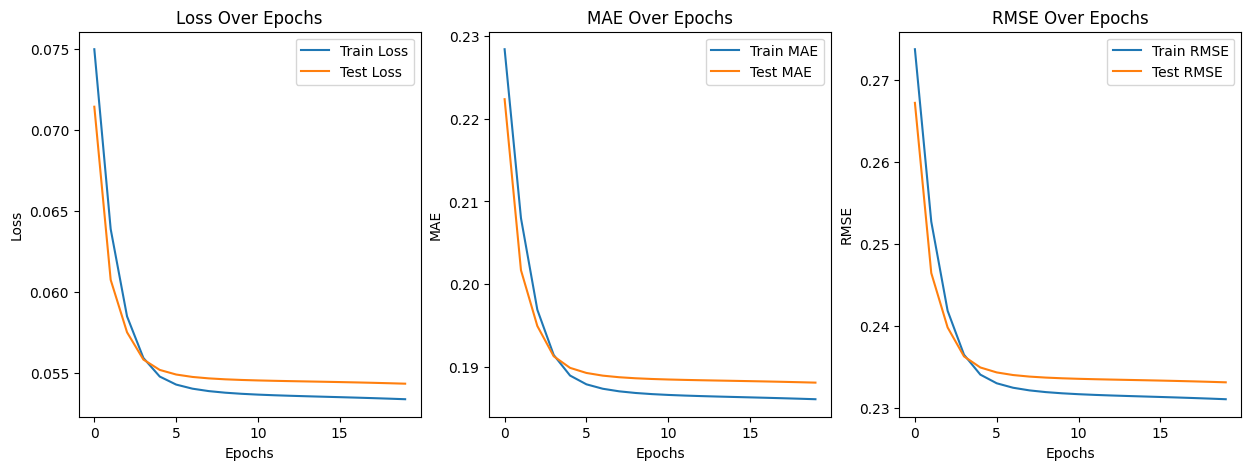

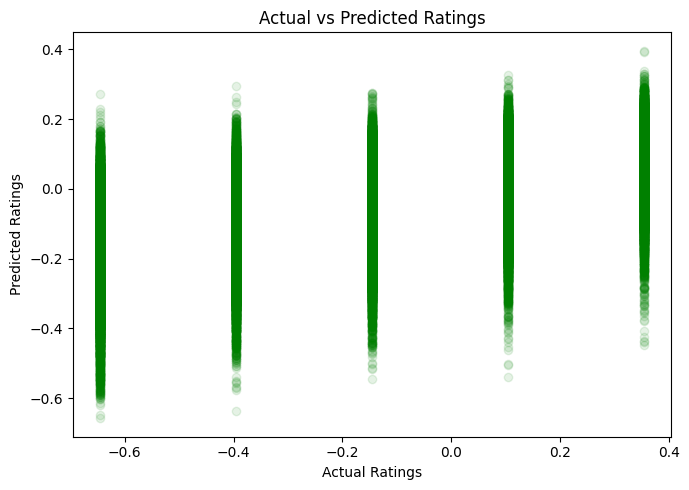

In [7]:
# ====================== Train Model ======================
model = SVD_SGD_Recommender(num_factors=50, learning_rate=0.1, reg=0.05, epochs=20)
model.fit(train_ratings, test_ratings, np.mean(ratings[['rating']]), ratings[['rating']].max(), ratings[['rating']].min())
# model.fit(train_ratings, test_ratings, 0, 0, 0)